# Supervised Learning Node Prediction
This program will generate a Supervised Learning model trained to predict the resultant properties of a given set of nodes in a graph

In [25]:
# Required Header
!pip install networkx numpy scikit-learn matplotlib pandas seaborn
%matplotlib inline

import networkx as nx
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from itertools import combinations
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Algorithm Declaration

In [26]:
# Generates a graph with random number of nodes and edges and a random graph type
def generate_random_graph():
    graph_type = np.random.choice(['erdos', 'watts', 'barabasi'])
    n_nodes = np.random.randint(10, 50)
    
    if graph_type == 'erdos':
        p = np.random.uniform(0.1, 0.9)
        graph = nx.erdos_renyi_graph(n_nodes, p)
    elif graph_type == 'watts':
        k = np.random.randint(2, min(6, n_nodes-1))
        p = np.random.uniform(0.1, 0.9)
        graph = nx.watts_strogatz_graph(n_nodes, k, p)
    else:  # barabasi
        m = np.random.randint(1, 5)
        graph = nx.barabasi_albert_graph(n_nodes, m)
    
    return graph

def extract_features(graph, nodes):
    features = []
    
    # Existing node features
    for node in nodes:
        # Basic metrics
        degree = graph.degree[node]
        clustering = nx.clustering(graph, node)
        avg_neighbor_degree = np.mean([graph.degree[n] 
                           for n in graph.neighbors(node)]) if list(graph.neighbors(node)) else 0
        
        # Centrality metrics
        betweenness = nx.betweenness_centrality(graph)[node]
        closeness = nx.closeness_centrality(graph)[node]
        pagerank = nx.pagerank(graph)[node]
        eigenvector = nx.eigenvector_centrality(graph, max_iter=100)[node]
        
        # Structural metrics
        core_number = nx.core_number(graph)[node]
        local_efficiency = nx.local_efficiency(graph)
        
        features.extend([
            degree,
            clustering,
            avg_neighbor_degree,
            betweenness,
            closeness,
            pagerank,
            eigenvector,
            core_number,
            local_efficiency
        ])
    
    # Graph-level features
    features.extend([
        nx.density(graph),
        nx.average_clustering(graph),
        len(graph.edges()) / len(graph.nodes()),
        np.mean([d for _, d in graph.degree()]),
        nx.transitivity(graph),
        nx.average_shortest_path_length(graph),
        nx.diameter(graph)
    ])
    
    return np.array(features)

def generate_training_data(num_samples=5000):
    """Generate training data with fixed dimensions"""
    X = np.zeros((num_samples, 43))  # Fixed size feature matrix
    y = np.zeros(num_samples)
    
    for i in range(num_samples):
        while True:
            try:
                # Create random graph
                n_nodes = np.random.randint(10, 20)
                p = np.random.uniform(0.2, 0.8)
                graph = nx.erdos_renyi_graph(n_nodes, p)
                
                # Check if graph is connected
                if nx.is_connected(graph):
                    # Select 4 random nodes
                    nodes = list(np.random.choice(graph.nodes(), 4, replace=False))
                    
                    # Extract features
                    X[i] = extract_features(graph, nodes)
                    y[i] = np.mean([nx.clustering(graph, node) for node in nodes])
                    break
            except:
                continue
    
    return X, y


## Simulation and Analysis

In [27]:
# Generate and prepare data
X, y = generate_training_data()
print(f"Generated dataset shape: X={X.shape}, y={y.shape}")

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
model = RandomForestRegressor(n_estimators=200, max_depth=15)
model.fit(X_train, y_train)

# Cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validation MSE: {-scores.mean():.4f} (+/- {scores.std() * 2:.4f})')

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': range(X_train.shape[1]),
    'importance': model.feature_importances_
})

print("\nAll feature importances:")
print(feature_importance.sort_values('importance', ascending=False))


Generated dataset shape: X=(1000, 43), y=(1000,)
Cross-validation MSE: 0.0019 (+/- 0.0006)

All feature importances:
    feature  importance
37       37    0.756438
17       17    0.035664
26       26    0.029726
28       28    0.027495
35       35    0.026717
8         8    0.025234
1         1    0.022329
40       40    0.021152
19       19    0.012308
10       10    0.009701
21       21    0.002408
2         2    0.002371
3         3    0.002085
24       24    0.001842
30       30    0.001687
12       12    0.001513
33       33    0.001458
31       31    0.001415
23       23    0.001387
41       41    0.001358
22       22    0.001244
5         5    0.001106
14       14    0.001062
15       15    0.000995
6         6    0.000991
20       20    0.000958
32       32    0.000936
36       36    0.000920
29       29    0.000917
4         4    0.000847
13       13    0.000843
11       11    0.000834
39       39    0.000498
38       38    0.000491
18       18    0.000491
25       25    0.00

Mean Squared Error: 0.0032
R² Score: 0.9375


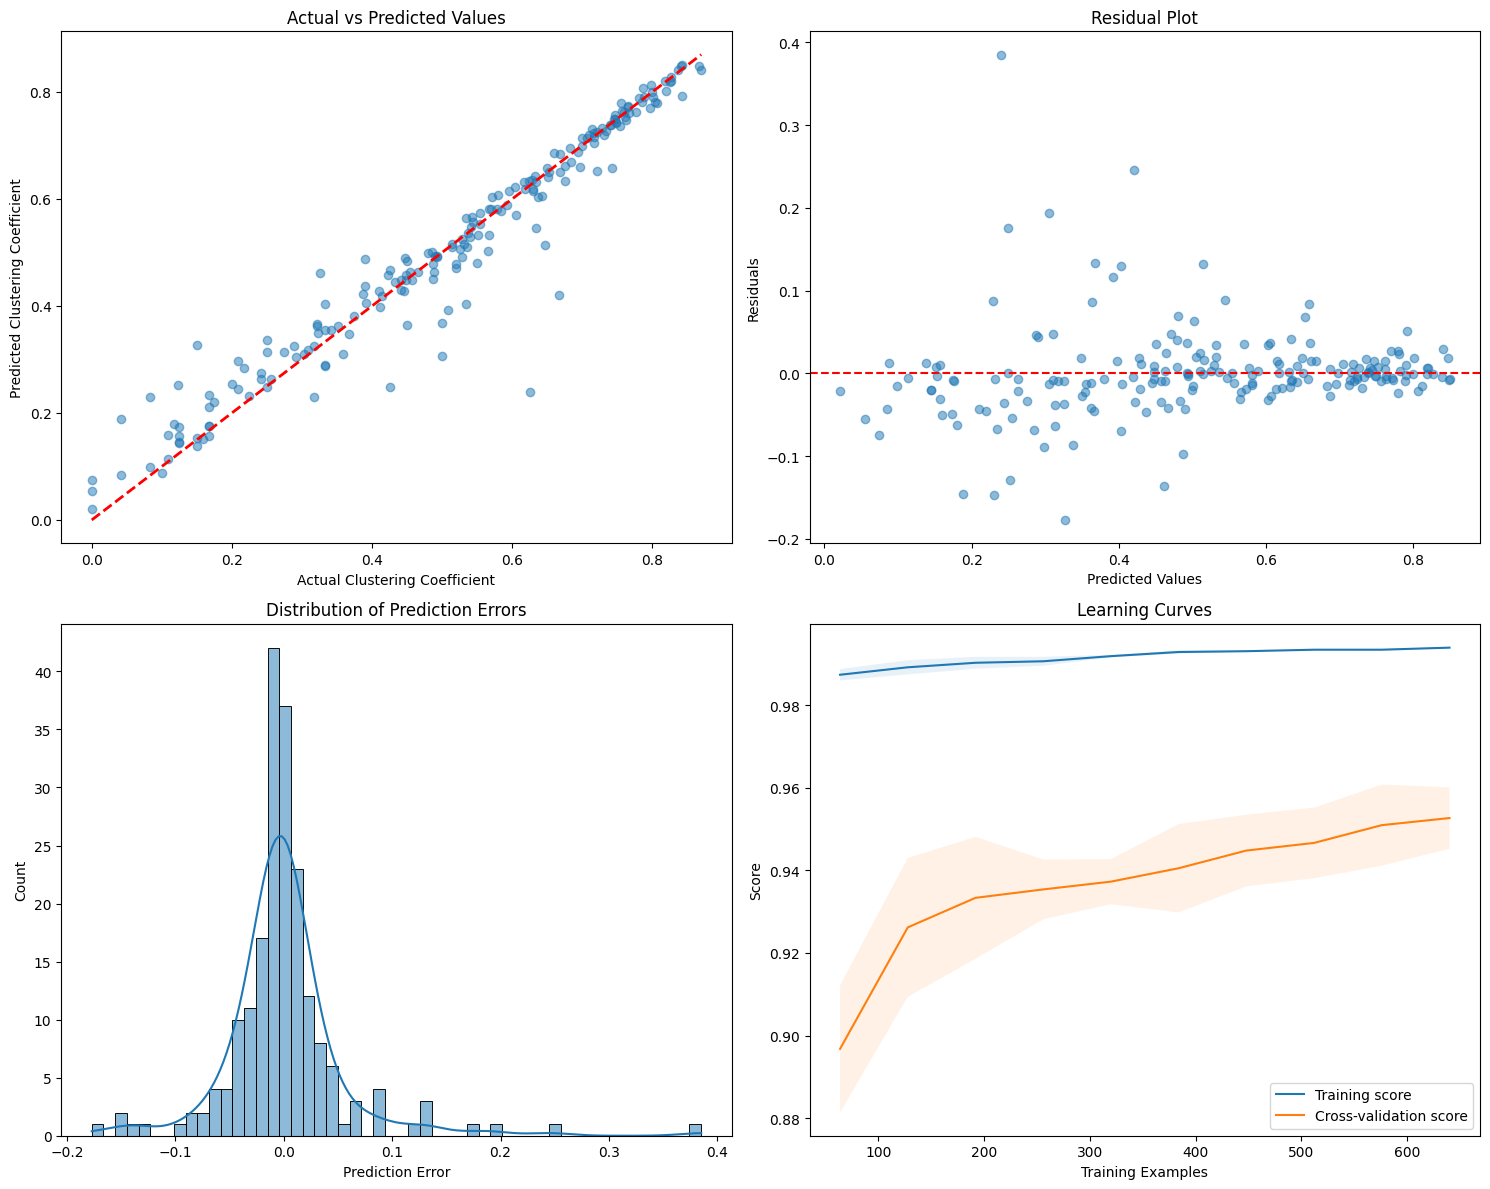

In [28]:
def plot_model_accuracy(model, X_test, y_test, X_train, y_train):
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Actual vs Predicted
    ax1.scatter(y_test, y_pred, alpha=0.5)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual Clustering Coefficient')
    ax1.set_ylabel('Predicted Clustering Coefficient')
    ax1.set_title('Actual vs Predicted Values')
    
    # 2. Residual Plot
    residuals = y_test - y_pred
    ax2.scatter(y_pred, residuals, alpha=0.5)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')
    
    # 3. Error Distribution
    sns.histplot(residuals, kde=True, ax=ax3)
    ax3.set_xlabel('Prediction Error')
    ax3.set_title('Distribution of Prediction Errors')
    
    # 4. Learning Curves
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    ax4.plot(train_sizes, train_mean, label='Training score')
    ax4.plot(train_sizes, test_mean, label='Cross-validation score')
    ax4.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    ax4.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    ax4.set_xlabel('Training Examples')
    ax4.set_ylabel('Score')
    ax4.set_title('Learning Curves')
    ax4.legend(loc='best')
    
    # Print metrics
    print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}')
    print(f'R² Score: {r2_score(y_test, y_pred):.4f}')
    
    plt.tight_layout()
    plt.show()

# Call the function after model training
plot_model_accuracy(model, X_test, y_test, X_train, y_train)